# 3. Sobel and Canny Edge Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Sobel Edge Detection](#sobel)
3. [Canny Edge Detection](#canny)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
import skimage.color as sc
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter as gauss
from scipy.ndimage import median_filter as med

## Sobel Edge Detection <a class="anchor" id="sobel" ></a>

As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values. 

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

1. Convert the color image to grayscale for the gradient calculation since it is two dimensional.
2. Compute the gradient in the x and y (horizontal and vertical) directions. 
3. Compute the magnitude of the gradient.
4. Normalize the gradient values. 

In [2]:
def edge_sobel(image):
    #from scipy import ndimage
    #import skimage.color as sc
    #import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

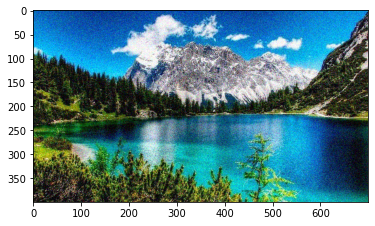

In [3]:
original_image = np.load('../data/img.npy')

img = skimage.util.random_noise(original_image)
plt.imshow(img)

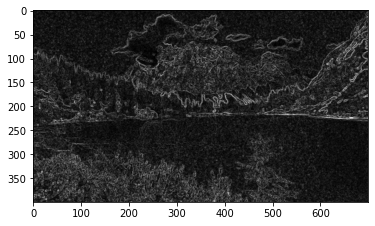

In [4]:
img_med = med(img, size=2)
img_edge = edge_sobel(img_med)
plt.imshow(img_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

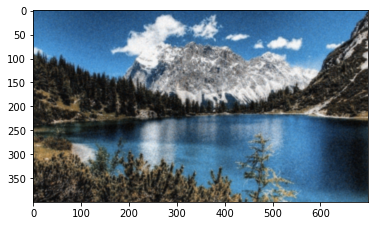

In [5]:
img_gauss = gauss(img, sigma=1)   
plt.imshow(img_gauss)

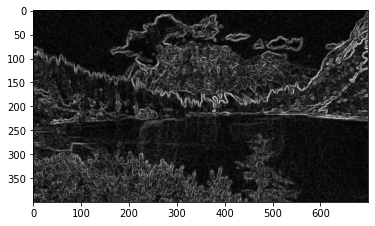

In [6]:
img_edge = edge_sobel(img_gauss)
plt.imshow(img_edge, cmap="gray")

## Canny Edge Detection <a class="anchor" id="canny" ></a>

Steps:
1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

**Pre-requisite:** Convert the image to grayscale before algorithm.

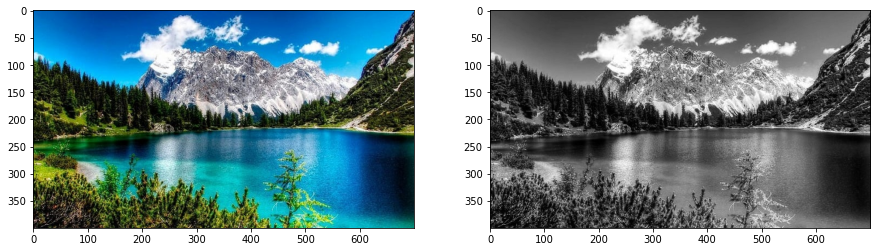

In [7]:
img = cv2.imread('../data/image.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [8]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [9]:
# Change this parameter
sigma = 10 # 1, 3, 5, 10, 20, ...

### 1.2 Kernel Size Parameter

In [10]:
kernel_size = 3

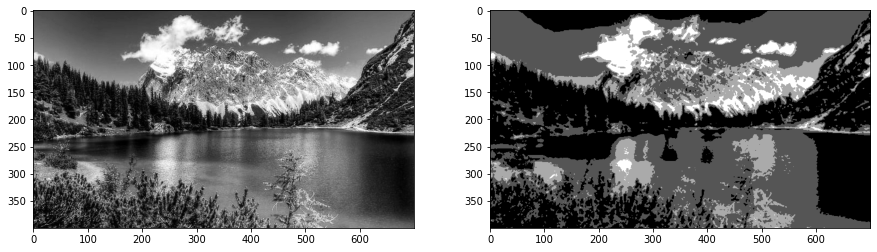

In [11]:
img_gaussian = convolve(img_gray, gaussian_kernel(kernel_size, sigma))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_gaussian, cmap="gray")

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity. 

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: 
- horizontal $(x)$ 
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [12]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_21595/65442114.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_21595/65442114.py:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


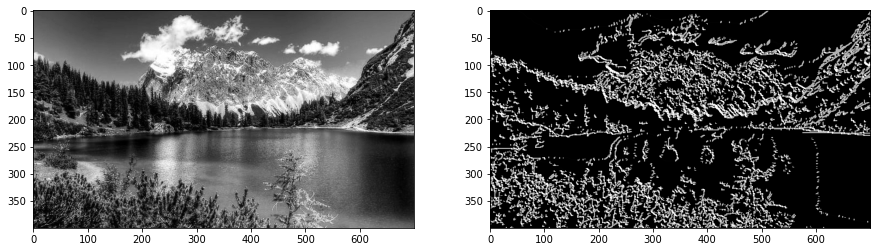

In [13]:
G, theta = sobel_filters(img_gaussian)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G, cmap="gray")

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [14]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

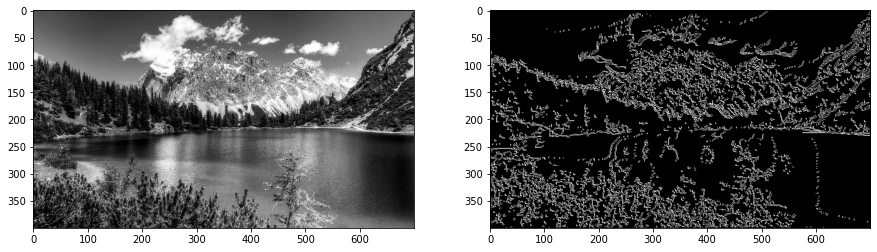

In [15]:
img_nonmax = non_max_suppression(G, theta)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax, cmap="gray")

### 4. Double threshold

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [16]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res)

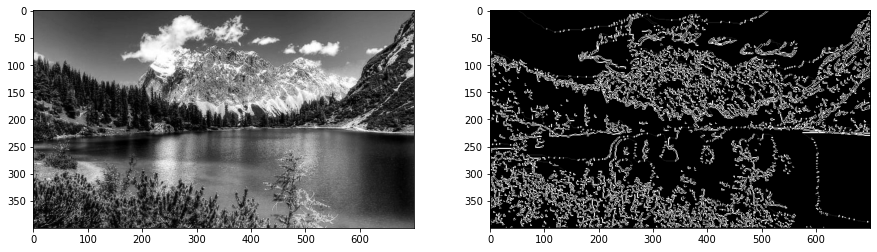

In [17]:
img_threshold = threshold(img_nonmax)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold, cmap="gray")

### 5. Edge Tracking by Hysteresis

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [18]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

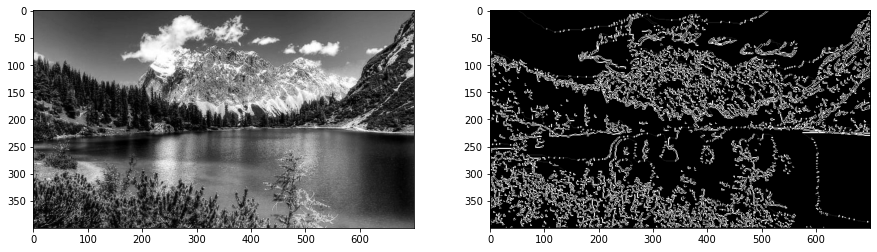

In [19]:
img_final = hysteresis(img_threshold)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

### Ejercicio 1

Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

**1a) Prewitt**

In [31]:
# Define Prewitt kernels
Px = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], np.float32)  # Horizontal kernel
Py = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)  # Vertical kernel

print('Kernel Prewitt horizontal:\n')
print(Px,'\n')
print('Kernel Prewitt vertical:\n')
print(Py)

Kernel Prewitt horizontal:

[[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]] 

Kernel Prewitt vertical:

[[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]


In [21]:
# Kernel convolution function
def convol(img, kernel):
    # image height and width
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # kernel height and width
    kernel_height = kernel.shape[0]
    kernel_width = kernel.shape[1]

    h = (kernel_height - 1) // 2    
    w = (kernel_width - 1) // 2

    # output image matrix
    out = np.zeros((img_height, img_width))

    # iterate over every pixel of the image
    for i in np.arange(h, img_height-h):
        for j in np.arange(w, img_width-w):
            sum = 0
            # iterate over the kernel
            for k in np.arange(-h, h+1):
                for l in np.arange(-w, w+1):
                    # get the corresponding image pixel value
                    a = img[i+k, j+l]
                    z = kernel[h+k, w+l]
                    sum += (z * a)
            out[i, j] = sum
    
    return out

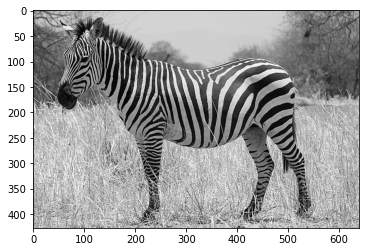

In [22]:
image1 = cv2.imread('../data/zebra.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image1, cmap='gray')

In [23]:
# Calculate the x and y gradients using the Prewitt kernels
prew_x = convol(image1, Px) 
prew_y = convol(image1, Py) 

In [24]:
# Calculate the magnitude of the gradient
prew_out = np.sqrt(np.power(prew_x, 2) + np.power(prew_y, 2))
# Map the values to range 0-255
prew_out = (prew_out / np.max(prew_out)) * 255 

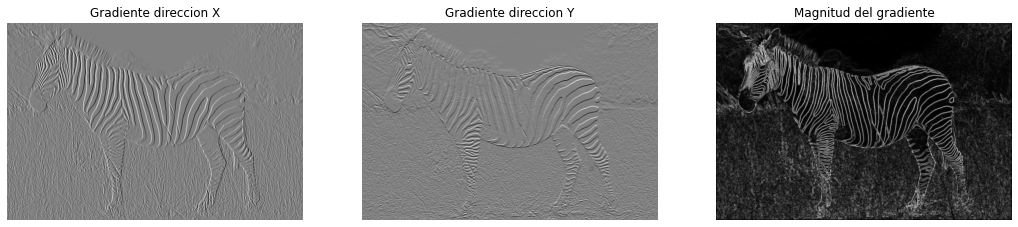

In [25]:
fig = plt.figure(figsize=(18, 16))

a = fig.add_subplot(1,3,1)
imgplot = plt.imshow(prew_x, cmap='gray')
a.set_title('Gradiente direccion X')
a.axis('off')

a = fig.add_subplot(1,3,2)
imgplot = plt.imshow(prew_y, cmap='gray')
a.set_title('Gradiente direccion Y')
a.axis('off')

a = fig.add_subplot(1,3,3)
imgplot = plt.imshow(prew_out, cmap='gray')
a.set_title('Magnitud del gradiente')
a.axis('off')

plt.show()

**1b) Sobel**

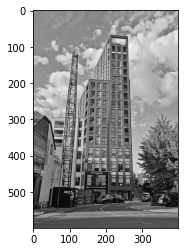

In [26]:
image2 = cv2.imread('../data/london.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image2, cmap='gray')

In [32]:
# Define Sobel kernels
Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)  # Horizontal kernel
Sy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)  # Vertical kernel

print('Kernel Sobel horizontal:\n')
print(Sx,'\n')
print('Kernel Sobel vertical:\n')
print(Sy)

Kernel Sobel horizontal:

[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]] 

Kernel Sobel vertical:

[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]


In [28]:
# Calculate the x and y gradients using the Sobel kernels
sob_x = convol(image2, Sx) 
sob_y = convol(image2, Sy) 

In [29]:
# Calculate the magnitude of the gradient
sob_out = np.sqrt(np.power(sob_x, 2) + np.power(sob_y, 2))
# Map the values to range 0-255
sob_out = (sob_out / np.max(sob_out)) * 255 

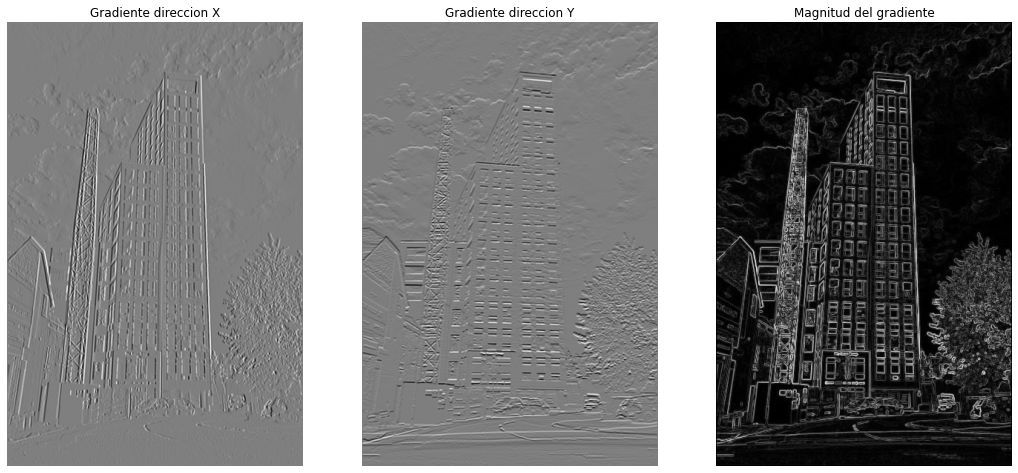

In [30]:
fig = plt.figure(figsize=(18, 16))

a = fig.add_subplot(1,3,1)
imgplot = plt.imshow(sob_x, cmap='gray')
a.set_title('Gradiente direccion X')
a.axis('off')

a = fig.add_subplot(1,3,2)
imgplot = plt.imshow(sob_y, cmap='gray')
a.set_title('Gradiente direccion Y')
a.axis('off')

a = fig.add_subplot(1,3,3)
imgplot = plt.imshow(sob_out, cmap='gray')
a.set_title('Magnitud del gradiente')
a.axis('off')

plt.show()

**1b) Laplacian**

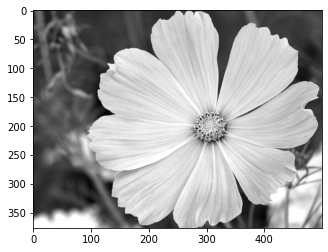

In [34]:
image3 = cv2.imread('../data/flor.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image3, cmap='gray')

In [35]:
def Laplacian(imagen3):
  laplacianX = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

  laplacianY = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

  #normalizing the vectors
  Lap_x = convolve(imagen3, laplacianX) / 28.0
  Lap_y = convolve(imagen3, laplacianY)  / 28.0

  #calculate the gradient magnitude of vectors
  lap = np.sqrt(np.power(Lap_x, 28) + np.power(Lap_y, 28))
  # mapping values from 0 to 255
  lap = (lap / np.max(lap)) * 255


  return lap

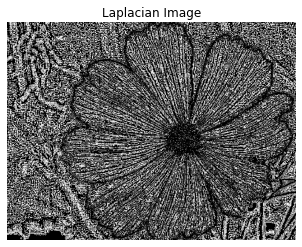

In [36]:
# Aplicar el filtro Laplaciano
lap = Laplacian(image3)

# Mostrar la imagen resultante
plt.imshow(lap, cmap='gray')
plt.title('Laplacian Image')
plt.axis('off')  # Desactivar ejes para mejor visualización
plt.show()

Prewitt y Sobel son métodos de gradiente  basados en la derivada de primer orden, ambas usan convolución de 3x3 por lo tanto el costo computacional es el mismo. Prewitt proporciona mayor inmunidad al ruido, le da la misma relevancia a la vecindad horizontal y vertical de un pixel cuando combina sus dos componentes de gradiente. En cambio, Sobel es más sensible a los bordes diagonales.
Por otra parte, el Laplaciano es una medida bidimensional isotrópica basado en la derivada de segundo orden de una imagen, es mucho más sensible al ruido, esta se suele utilizar en detección de puntos aislados.

En los tres casos la complejidad computacional es: **O(mn)** donde **m** y **n** son las dimensiones de la imagen. Por lo tanto, la complejidad en tiempo es lineal con respecto al número de pixeles de la imágen. La operación de convolucion es el principal factor que contribuye en la complejidad computacional de los tres algorítmos.

Al final, cada uno tiene sus ventajas y desventajas, en algunas aplicaciones se deberán combinar los gradientes y el laplaciano para detectar lo que realmente se está buscando. Tambien es importante mencionar que el tiempo de ejecución de cada algoritmo puede variar dependiendo de la implementación y técnicas de optimización utilizadas.

## Ejercicio 2 

Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

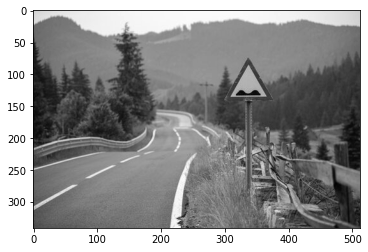

In [37]:
image4 = cv2.imread('../data/senal.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image4, cmap='gray')

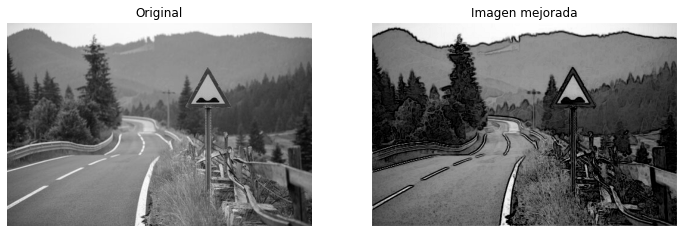

In [38]:
# Funcion que recibe una imagen en escala de grises
# Y un factor alpha

def realce_lineas(imagen, factor_alpha):
  # Calculate the x and y gradients using the Sobel kernels
  sobel_x = convol(imagen, Sx)
  sobel_y = convol(imagen, Sy)

  # Calculate the magnitude of the gradient
  sob_out = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))

  # Map the values to range 0-255
  sob_out = (sob_out / np.max(sob_out)) * 255

  # Multiplicar la magnitud del gradiente por el factor_alpha
  imagen_realzada = np.clip(sob_out * factor_alpha, 0, 255).astype(np.uint8)

  # Aplicar la diferencia entre la imagen original y la imagen realzada
  imagen_final = cv2.subtract(imagen, imagen_realzada)

  return imagen_final

# Factor de realce (Mayor a 1 como se requiere en el ejercicio)
factor_alpha = 2.0

# Aplicar el algoritmo de realce de líneas
imagen_realzada = realce_lineas(image4, factor_alpha)

# Ahora solamente mostramos las figuras original vs mejorada
fig = plt.figure(figsize=(12, 8))

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(image4, cmap='gray')
a.set_title('Original')
a.axis('off')

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(imagen_realzada, cmap='gray')
a.set_title('Imagen mejorada')
a.axis('off')

plt.show()

## Ejercicio 3 

Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de image

X-ray image of a PET, corrupted by salt-and-pepper noise

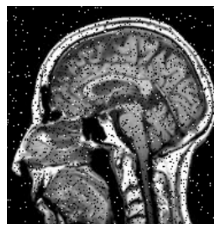

In [39]:
# Read the image
image5 = plt.imread('../data/head.png')
plt.axis('off')
plt.imshow(image5, cmap='gray')

### Noise reduction using a 19 × 19 Gaussian lowpass filter kernel with s = 3.

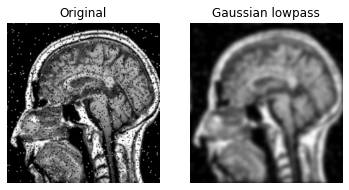

In [40]:
from scipy.signal import convolve2d

def read_image(image):
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    return image

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def gaussian_blur(image, kernel):
    return convolve2d(image, kernel, mode='same', boundary='wrap')

# Convert to grayscale
image6 = read_image(image5)

# Define Gaussian kernel
kernel = 19
sigma = 3
gaussian_kernel = gaussian_kernel(kernel, sigma)

# Apply Gaussian blur
gaussian_img = gaussian_blur(image6, gaussian_kernel)

# Display the original and Gaussian lowpass
plt.subplot(1, 2, 1), plt.imshow(image6, cmap='gray'), plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(gaussian_img, cmap='gray'), plt.title('Gaussian lowpass')
plt.axis('off')
plt.show()

### Noise reduction using a 7 × 7 median filter

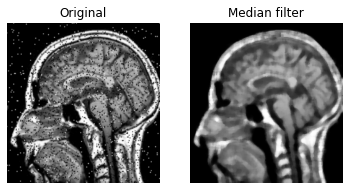

In [41]:
def read_image(image):
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    return image

def median_filter(image, filter_size):
    padded_image = np.pad(image, filter_size // 2, mode='reflect')
    result_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result_image[i, j] = np.median(padded_image[i:i+filter_size,
                                                        j:j+filter_size])

    return result_image

# Convert to grayscale
image7 = read_image(image5)

# Define median
med = 7

# Apply a 7x7 median filter
median = median_filter(image7, med)

# Display the original and median image
plt.subplot(1, 2, 1), plt.imshow(image7, cmap='gray'), plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(median, cmap='gray'), plt.title('Median filter')
plt.axis('off')
plt.show()

---



Bibliografía
* https://medium.com/@nikatsanka/comparing-edge-detection-methods-638a2919476e
* Gonzalez, R. & Woods, R. (2018). Digital Image Processing.  4° Edition. Pearson.
* Parik, D. (s.f.). *Edge Detection using Laplacian Filter*. OpenGenus. https://iq.opengenus.org/laplacian-filter/
* Olawanle, J. (2022, 5 de octubre). *Big O Cheat Sheet – Time Complexity Chart*. FreeCodeCamp. https://www.freecodecamp.org/news/big-o-cheat-sheet-time-complexity-chart/